# HW4-1 : Training generative model to generate MNIST digits
This homework consists of 4 tasks:
1. ***Implement Variational AutoEncoder (VAE) and its training***
2. Implement Generative Adversarial Network (GAN) and its training
3. Implement Conditonal Generative Adversarial Network (cGAN) and its training
4. Implement Fréchet inception distance (FID) score


In this file, you are asked to perform ***Task 1*** and complete several functions and classes in `HW4_1_YourAnswer.py`. In the notebook, the place where students are required to complete the codes will be denoted as Exercise or TODO

The score for this homework is based on:
- How correctly you implement the code (Each component will be tested)

# Setting system path
## TODO
- Depending on your environment, select your proper code between `1 Setting on the colab` or `2. Setting on the local` Section. (You should comment out the other section)
- Set proper `path` variable to import `HW4_1_YourAnswer.py` and `your_answer_fid.py`

### 1. Setting on the colab
It allows to connect your google drive to colab and utilize files in your google drive

Then, it changes the current directory to the path the howework folder is located.

### TODO
- Assign the path of your working directory (where the .ipynb file is located) to the variable named `path`.

In [2]:
path = "MyDrive/Colab Notebooks/Intro_dl/hw4"  ######## YOUR WORKING DIRECTORY PATH HERE ########
def mount_drive():
    from google.colab import drive
    mount_location = '/content/drive'
    drive.mount(mount_location,force_remount=True)
    return mount_location
import os, sys
mount_location = mount_drive()
print("your google drive is mounted at: ", mount_location)
path = os.path.join(mount_location,path) # "/content/drive/MyDrive/"
if os.path.exists(path):
    print("Path exists\n\t", path)
    sys.path.append(path)
    print("Path added (file under this path automatically identified)\n\t", path)
    os.chdir(path)
else :
    raise ValueError("Path does not exist. Set proper path \n", path)

Mounted at /content/drive
your google drive is mounted at:  /content/drive
Path exists
	 /content/drive/MyDrive/Colab Notebooks/Intro_dl/hw4
Path added (file under this path automatically identified)
	 /content/drive/MyDrive/Colab Notebooks/Intro_dl/hw4


### 2. Setting on the local

In [ ]:
path='./'
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Check whether the path is set correctly in the homework folder

In [ ]:
!ls $path

2023_SNU_DL_HW4_1.ipynb  fid_score.cpython-310-x86_64-linux-gnu.so
2023_SNU_DL_HW4_2.ipynb  sprite_labels_nc_1788_16x16.npy
HW4_1_YourAnswer.py	 sprites_1788_16x16.npy
HW4_2_YourAnswer.py	 test_GAN_one_iter.cpython-310-x86_64-linux-gnu.so
HW4_fid_YourAnswer.py	 test_file
__pycache__		 utils.py


## Import package and set serveral configs

In [3]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from math import sqrt
from HW4_1_YourAnswer import *
from utils import *

%load_ext autoreload
%autoreload 2

In this exercise, you need to change hyperparameter in `config`.

In [4]:
from types import SimpleNamespace

# The config is used to store various hyperparameters
# you don't need to change it
# you can access the hyperparameters by config.xxx
config = SimpleNamespace(
    seed = 1,
    batch_size = 256,
    test_batch_size = 100,
    lr = 2e-4,
    epoch = 10,
    latent_dim = 2,
    input_shape = (1,16,16),
    hidden_dims = [256,128,64,32],
    expand_dim = 2,
    beta = 2,
)

## TODO
- Write your student number here as a string

In [5]:
config.student_number = '2019-12172'

In [6]:
# Check device is 'cuda' if GPU is available
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cuda'

In [7]:
# set randomness
set_randomness(config.seed)

# Beta Variational AutoEncoder (beta-VAE)
The exercise in this section is based on the following paper:
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://openreview.net/pdf?id=Sy2fzU9gl)

In this section, you are asked to implement beta Variational AutoEncoder (beta-VAE) and training. The VAE is a generative model that can be trained in an unsupervised manner. The beta-VAE is a variant of the VAE that can learn disentangled representations. They introduce an adjustable hyperparameter `beta` that balances latent channel capacity and independence constraints with reconstruction accuracy.

The only difference between VAE and beta-VAE is the `loss function`. The beta-VAE and VAE have no difference in terms of the architecture. Therefore, we `take the same approach as the VAE` except for constructing the loss function.

The VAE is composed of two parts: an encoder and a decoder. The encoder encodes the input data into a latent vector, and the decoder decodes the latent vector into the output data. The encoder and decoder are trained simultaneously.

Before you implement the VAE, you need to build your own AutoEncoder(AE). The encoder in the AE encodes the input data into a latent vector, and it is directly passed to the decoder. The decoder in the AE decodes the latent vector into the output data. The encoder and decoder are trained simultaneously.

The difference between AE and VAE is that the AE does not consider the distribution of the latent vector. The AE is trained to minimize the reconstruction error between the input data and the output data. On the other hand, the VAE is trained to minimize the reconstruction error and the KL divergence between the latent vector and the prior distribution. (The identical reconstruction error will be used) For later comparison between AutoEncoder and Variational AutoEncoder, you are asked to implement shared model architecture for both AutoEncoder and Variational AutoEncoder.

Here is how the input data flows and the output are generated for the AutoEncoder and Variational AutoEncoder (self.xxx indicates the layer or model in the `Encoder` class):
```
    AutoEncoder
        - input -> self.model -> self.fc_mean -> final output (will be passed to the decoder)
    
    Variational AutoEncoder
        - input -> self.model -> intermediate output
        - intermediate output -> self.fc_mean    -> output (one latent vector, mean)
        - intermediate output -> self.fc_logvar  -> output (one latent vector, logvar)
        - two latent vectors (mean and logvar)   -> self.reparameterize -> final output (will be passed to the decoder)
```

Here is the config for the AutoEncoder and Variational AutoEncoder:
```
    AutoEncoder
        - beta: 0
        - loss function: reconstruction loss
    
    Variational AutoEncoder
        - beta: 1
        - loss function: VAE loss (reconstruction loss + KL divergence)
```
The only difference between AE and VAE is the `loss function` and `reparameterization`.


You are asked to implement the following functions and classes for AutoEncoder and Variational AutoEncoder in `HW4_1_YourAnswer.py`:
- `Encoder` class for both AE and VAE
- `Decoder` class
- `loss function` concerning Evidence Lower Bound (ELBO)
- `training_VAE` for training AE and VAE

After you complete implementation, you are asked to train AE, VAE, and beta-VAE. Afterward, you can see the their generated result, loss curve, and some visualizations such as the latent space mapping.

## Exercise 1. Encoder
In this exercise, you are asked to implment `Encoder` class. The `Encoder` class is composed of four convolutional layers and two fully-connected layers. The input of the `Encoder` class is an image tensor, and the output is a latent vector. The function you are asked to implement in the `Encoder` class is as follows:
- \_\_init\_\_ : Define model structure with `self.model, self.fc_mean, self.fc_logvar`
- reparameterize : (Only used in VAE) Reparameterize the latent vector with `mean` and `logvar`
- forward : Forward propagation

The Encoder could work as Encoder in AutoEncoder and Variational AutoEncoder. The operation depends on the argument `model_name` passed into the `Encoder` class.
- If `model_name` is `AE`, the Encoder works as Encoder in AutoEncoder.
- If `model_name` is `VAE`, the Encoder works as Encoder in Variational AutoEncoder.
    - `beta-VAE` is also a variant of the VAE. Therefore, you can use the `VAE` model for `beta-VAE`.

For VAE, you need to implement the `reparameterize` function in the `Encoder` class. The `reparameterize` function is used to reparameterize the latent vector. The latent vector is sampled from the Gaussian distribution with `mean` and `logvar`. The `reparameterize` function is defined as follows:

### 1.1. \_\_init\_\_
In this function, you are asked to implement the initialization of the `Encoder` class for AutoEncoder. The input of the `Encoder` class is an image tensor, and the output is a latent vector. The `input_dim` is the dimension of the input image, and the `hidden_dim` is the dimension of the hidden layer. The `latent_dim` is the dimension of the latent vector.
### TODO
- Implement the `__init__` function in `Encoder` class

If you implement the `Encoder` class correctly, you can get the following result:

For AE, the `__init__` function is as follows:
```
(model): Sequential(
    (0): Conv2d(in_channels, hidden_dim[0], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(hidden_dim[0], hidden_dim[1], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(hidden_dim[1], hidden_dim[2], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(hidden_dim[2], hidden_dim[3], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (fc_mean): Linear(in_features=hidden_dim[3], out_features=2, bias=True)
  (fc_logvar): Linear(in_features=hidden_dim[3], out_features=2, bias=True)
```
In Autoencoder, the `fc_mean` layer works as last layer and outputs the latent vector (`fc_logvar` is defined, but not used). Then, the latent vector directly passes to the `Decoder`.

In Variational AutoEncoder, the outputs of `fc_mean` and `fc_logvar` layers are used to reparameterize the latent vector. Then, the reparameterized latent vector  passes to the `Decoder`.

### TODO
- build the model structure with `self.model, self.fc_mean, self.fc_logvar` with given `in_channels`, `hidden_dim`, and `latent_dim`
- ***You need to use `in_channels, hidden_dim, and latent_dim`*** which are passed to the Encoder. The architecture could be changed with the argument passed to the `Encoder` class.

In [8]:
from HW4_1_YourAnswer import Encoder
# for AE and VAE
encoder = Encoder(hidden_dims = config.hidden_dims,
                  latent_dim=config.latent_dim,model_name='AE').to(device) # or model_name='VAE'
print(encoder)

Encoder(
  (model): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (fc_mean): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
)


### 1.2 forward for AutoEncoder
In this function, you are asked to implement the forward path of the `Encoder` class. The forward path of the `Encoder` class is as follows:
- Input image tensor is passed through the convolutional layers
- The output of the convolutional layers is passed through the one fully-connected layers (`fc_mean`).
- The output of the fully-connected layers (`self.fc_mean`) will be returned
    - Need to flatten the output of the convolutional layers before passing through the fully-connected layers

### TODO
- Implement the `forward` function in `Encoder` class for AutoEncoder

If you implement the `forward` function correctly, you can get the following output shape:
- (batch_size, latent_dim)

and you will get the following result:
```
    torch.Size([2, 2])
```

In [9]:
encoder = Encoder(hidden_dims = config.hidden_dims,
                  latent_dim=config.latent_dim,model_name='AE').to(device)
image = cv2.imread("./test_file/GAN_0050.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18]
image = image/255
image = torch.Tensor(image).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)
out = encoder(image)
print(out.shape)

torch.Size([2, 2])


### 1.3 reparameterize trick for VAE
The implementation of `Encoder` for `AE` is done. It is time to construct `Encoder` for `VAE`. For the first step, you need to implement the `reparameterize` function in the `Encoder` class.

In this function, you are asked to implement the reparameterization trick. The reparameterization trick is as follows:
- Sample a random vector $\epsilon$ (in our code, `eps`) from the standard normal distribution
- Compute the latent vector (in our code, `rp`) by $\mu + \sigma \odot \epsilon$, where $\mu$ and $\sigma$ are the mean and standard deviation of the latent distribution, respectively. $\odot$ is the element-wise multiplication.
- Return the latent vector `rp`

### TODO
- Implement the `reparameterize` function in `Encoder` class
    - In our code, `mu` is the mean of the latent distribution, and `logvar` is the log standard deviation of the latent distribution.
    - `eps` is the random vector sampled from the standard normal distribution and obtained from argument of the `reparameterize` function (Do not need to consider making it.).
    
If you implement the `reparameterize` function correctly, you can get the following result:
```
tensor([ 0.0051, -0.0005], device='cuda:0')
```

In [10]:
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='VAE').to(device)
eps = torch.Tensor([0.1,-0.01]).to(device)
mu = torch.Tensor([-0.1,0.01]).to(device)
logvar = torch.Tensor([0.1,0.1]).to(device)
out = encoder.reparametrize(mu, logvar,eps)
print(out)

tensor([ 0.0051, -0.0005], device='cuda:0')


### 1.4 forward function for VAE
In this function, you are asked to implement the forward path of the `Encoder` class for VAE. The forward path of the `Encoder` class is as follows:
- Input image tensor is passed through the convolutional layers
- The output of the convolutional layers is passed through the two fully-connected layers (`fc_mean`, `fc_logvar`), respectively.
    - Need to flatten the output of the convolutional layers before passing through the fully-connected layers
- The ***two output*** (`mu`,`logvar`) of the fully-connected layers is to through the `reparameterize` function

### TODO
- Implement the `forward` function in `Encoder` class

If you implement the `forward` function correctly, you can get the following output shape:
- `mean`: (batch_size, latent_dim)
- `logvar`: (batch_size, latent_dim)
- `rp`: (batch_size, latent_dim)

and you will get the following result:
```
```
    torch.Size([2, 2]) torch.Size([2, 2]) torch.Size([2, 2])
```

In [11]:
image = cv2.imread("./test_file/GAN_0050.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18]
image = image/255
image = torch.Tensor(image).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)
mean, logvar, rp = encoder(image)
print(mean.shape, logvar.shape, rp.shape)

torch.Size([2, 2]) torch.Size([2, 2]) torch.Size([2, 2])


## Exercise 2. Decoder
In this exercise, you are asked to implment `Decoder` class. The `Decoder` class is composed of four convolutional layers. The `self.decoder` architecture is reverse version of `Encoder` except `fc_mean` and `fc_logvar` layer. The input of the `Encoder` class is an image tensor, and the output is a latent vector. The function you are asked to implement in the `Encoder` class is as follows:
- \_\_init\_\_ : Define model structure with `self.input_layer, self.model,self.last_layer`
- forward(self, x)

### 2.1. \_\_init\_\_
In this exercise, you are asked to complete the initialization of the `Decoder` class. The `Decoder` class is composed of four convolutional layers. The architecture is reverse version of `Encoder`. The input of the `Encoder` class is an image tensor, and the output is a latent vector. The `input_dim` is the dimension of the input image, and the `hidden_dim` is the dimension of the hidden layer. The `latent_dim` is the dimension of the latent vector.

`self.input_layer` works as the first layer of the `Decoder`. The output of the `self.input_layer` is reshaped to `(B,self.hidden_dims[-1],self.expand_dim,self.expand_dim)`. Then, the reshaped output is passed through the `self.decoder` layers. The output of the `self.decoder` layers is passed through the `self.last_layer` layer. The output of the `self.last_layer` layer is the output of the `Decoder`.

### TODO
- Implement the decoder model with `self.input_layer, self.decoder, self.last_layer` in `__init__` function of `Decoder` class
- ***You need to use `latent_dim, hidden_dim, and expand_dim`*** which passed to the `Decoder` class. The architecture could be changed with the argument passed to the `Decoder` class.

If you implement the `Decoder` class correctly, you can get the following result:
```
Decoder(
  (input_layer): Linear(in_features=latent_dim, out_features=self.hidden_dims[3] * self.expand_dim**2 , bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(self.hidden_dims[3], self.hidden_dims[2], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d( self.hidden_dims[2],  self.hidden_dims[1], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d( self.hidden_dims[1],  self.hidden_dims[0], kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (last_layer): Sequential(
    (0): ConvTranspose2d(self.hidden_dims[0], 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)
```

In [12]:
from HW4_1_YourAnswer import *
print(config.hidden_dims)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
print(decoder)

[256, 128, 64, 32]
Decoder(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (last_layer): Sequential(
    (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)


### 2.2 forward
In this function, you are asked to implement the forward function of the `Decoder` class. The forward function of the `Decoder` class is as follows:
- Input latent vector is passed through the `self.input_layer`
- The output of the fully-connected layer is reshaped to `(B,self.hidden_dims[-1],self.expand_dim,self.expand_dim)`
- The output of the fully-connected layer is passed through `self.decoder`
- The output of the convolutional layers is passed through `self.last_layer`

### TODO
- Implement the forward path of the `Decoder` class

If you implement the `forward` function correctly, you can get the following decoder output shape:
```
For AE, decoder output : torch.Size([2, 1, 16, 16])
For VAE, decoder output : torch.Size([2, 1, 16, 16])
```

In [13]:
from HW4_1_YourAnswer import Encoder, Decoder
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
input = torch.randn(2, 1, 16, 16).to(device)
# AE case
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='AE').to(device)
latent = encoder(input)
out = decoder(latent)
print("For AE, decoder output :",out.shape)
# VAE case
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='VAE').to(device)
mean, logvar, rp = encoder(input)
out = decoder(rp)
print("For VAE, decoder output :",out.shape)

For AE, decoder output : torch.Size([2, 1, 16, 16])
For VAE, decoder output : torch.Size([2, 1, 16, 16])


## Exercise 3. Loss function (Evidence Lower Bound)
In this exercise, you are asked to implement the loss function of the `AE` and `beta-VAE`.
The `Encoder` and `Decoder` follows the below:
- The output of the 'Encoder' class follows the `Gaussian distribution` for the `VAE` family and does not follow any distribution for the `AE`.
- The output of the 'Decoder' class follows the `Bernoulli distribution`.

Before you implement the loss function of the VAE, you need to implement the loss function of the AE.

The loss function of the AE is as follows:
- AE loss
    - $L_{AE} = L_{rec}$

Where $L_{rec}$ is reconstruction loss (same loss for VAE and beta-VAE).

And, the loss function of the beta-VAE is as follows:
- VAE loss
    - $L_{VAE} = L_{rec} + \beta L_{KL}$

    
Where $L_{rec}$ is reconstruction loss and $L_{KL}$ is KL divergence loss. $\beta$ is the hyperparameter that balances the latent channel capacity and independence constraints with reconstruction accuracy.

When $\beta$ is 1, the loss function is the same as the VAE.

### TODO
- Implement `reconstruction loss` function for $L_{rec}$
    - Sum over every pixels and average for each batch
- Implement `KLD_loss` function (KL divergence loss) for $L_{KL}$
    - Do not average, just sum the loss
- Implement `loss_function` for training VAE
- ***Write you own code***
    - Do not use the function in `torch.nn.functional` or other `torch` package function which directly compute the loss.
    
Depending on the your implementation, it might be different from the result of the `torch` package function. However, ***please follow the above loss function instruction and standard formulation for these losses.***
If you implement the `loss_function` correctly, you can get the following result without error (small difference is allowed if no error is occured):
```
======== your implementation outcome is
- loss 191.0272216796875
- recon_loss 191.01107788085938
- kld_loss 0.016147971153259277
======== The results should be
- loss 191.0272216796875
- recon_loss 191.01107788085938
- kld_loss 0.016147971153259277
```

In [15]:
from HW4_1_YourAnswer import *
from utils import *
import cv2
config.latent_dim = 2
image1 = cv2.imread("./test_file/GAN_0050.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18] / 255
image1 = torch.Tensor(image1).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)
image2 = cv2.imread("./test_file/GAN_0100.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18] / 255
image2 = torch.Tensor(image2).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)

encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim).to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
# If you have trouble loading the model, please check the model architecture
encoder.load_state_dict(torch.load('./test_file/init_encoder.pth',map_location=device))
decoder.load_state_dict(torch.load('./test_file/init_decoder.pth',map_location=device))


eps = torch.Tensor([0.1,-0.01]).to(device)
mean1, logvar1, rp1 = encoder(image1,eps)

recon_image1 = decoder(rp1)
result = loss_function(recon_image1,image1,mean1,logvar1,return_info=True)

reference_result = torch.load('./test_file/test_results_VAE_loss.pth',map_location=device)

print("======== your implementation outcome is")
for key, value in result.items():
    print("-",key, value.item())
print("======== The results should be")
for key, value in reference_result.items():
    print("-",key, value.item())

assert abs(result['loss'].item() - reference_result['loss'].item()) < 1e-2, f"Wrong loss function implementation {result['loss'].item()}"
assert abs(result['recon_loss'].item() - reference_result['recon_loss'].item()) < 1e-2, f"Wrong reconstruction loss function implementation {result['recon_loss'].item()}"
assert abs(result['kld_loss'].item() - reference_result['kld_loss'].item()) < 1e-2, f"Wrong KLD loss function implementation {result['kld_loss'].item()}"

======== your implementation outcome is
- loss 191.02725219726562
- recon_loss 191.0111083984375
- kld_loss 0.01614794135093689
======== The results should be
- loss 191.0272216796875
- recon_loss 191.01107788085938
- kld_loss 0.016147971153259277


To check the correctness of the `loss function`, change beta value to 1,5,10 and check the result. If you implement the `loss function` correctly, you can get the following result:
```
    beta 1	: 48.04874801635742
    beta 5	: 48.07823181152344
    beta 10	: 48.115089416503906
```

In [16]:
mu = torch.Tensor([[-0.1,0.01],[0.05,-0.01]]).to(device)
logvar = torch.Tensor([[0.1,0.1],[0.05,0.1]]).to(device)
for beta in [1,5,10]:
    loss = loss_function(image1,image1,mu,logvar,beta=beta)
    print(f"beta {beta}\t:",loss.item())

beta 1	: 48.04874801635742
beta 5	: 48.07823181152344
beta 10	: 48.115089416503906


## Exercise 4. Training beta-VAE
In this exercise, you are asked to implement the training code of the beta-VAE. The training flow of the beta-VAE is as follows (Same as the VAE):
- Input image tensor is passed through the `Encoder` class
- The output of the `Encoder` class is passed through the `Decoder` class
- The outputs of the `Decoder` class and `Encoder` class are compared with the input image tensor using the `loss function`.
- The loss is backpropagated to update the parameters of the `Encoder` and `Decoder` classes
- Update the parameters of the `Encoder` and `Decoder` classes

For training, you need to implement the following functions and classes:
- Define dataloader in the `__init__` function of the `dataloader` class
- Define `self.optimizer` in the `__init__` function of the `training_VAE` class
- Implement `one_iter_train` of the VAE in the `training_VAE` class


### 4.1. Implement dataloader for training procedure
In this exercise, you are asked to implement the `dataloader` class. The `dataloader` class is used to load the MNIST dataset.

To implement dataloader, you need to define `preprocessing` and `dataloader` for dataset. The implementation sequence is as below:
1. implement `preprocessing` via `torchvision.transforms`
    - The `preprocessing` consists some transformation or processsing before loading on the network, such as normalization, resize, or other data augmentation.
2. Declare `dataset` via `torchvision.datasets`.
    - In VAE, you are asked to download and load the `MNIST`from the online.
    - In this seqeuence, the `preprocessing` is applied with `transform` argument.
3. Create `dataloader` which directly feeds the image into GAN networks.
    - It defines batch size, shuffling option, or etc.

### 4.1.1 Preprocessing the dataset
In this exercise, we implement the transformation function via `torchvision.transforms`.
The preprocessing for the input consists of 3 components:
1. Resize the image
    - The expected image shape for the generator and discriminator  is (1,16,16), but the original image shape of MNIST is (1,28,28). To align it, the input image should be `resize` into (1,16,16).
2. Change the data type
    - You need to `change variable type` from numpy array `into torch.Tensor` to train neural network since the network expects torch.Tensor type input.
    
For more details, see the [link](https://pytorch.org/vision/0.9/transforms.html).

### TODO
- Implement transformation (preprocessing) for the input image in `dataloader` class (The code in `HW4_1_YourAnswer.py`)

If implemented correctly, the results will as shown:
```
Compose(
    Resize(size=16, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
```

In [17]:
from HW4_1_YourAnswer import *
loader_for_test = dataloader(train=False, batch_size=config.batch_size)
print(loader_for_test.transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 231592466.87it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 152756234.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 117459389.54it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 25000693.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Compose(
    Resize(size=16, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


### 4.1.2 Implement dataset and dataloader
In this practice, you are asked to implement dataset and dataloader.
### TODO
- Implement self.dataset to load MNIST dataset using `torchvision.datasets`. (The code in `HW4_1_YourAnswer.py`)
- Implement self.dataloader (The code in `HW4_1_YourAnswer.py`)

If you implemented correctly, the output will be as below (min / max value might be different, just check the value is in the range of 0~1):
```
The shape of image from the dataloader : torch.Size([10, 1, 16, 16])
The type of image from the dataloader : <class 'torch.Tensor'>
The min/max of image from the dataloader : 0.0 / 0.9921568632125854
The shape of label from the dataloader : torch.Size([10])
```

In [18]:
from HW4_1_YourAnswer import *
loader_for_test = dataloader(train=False, batch_size=10)
for img, label in loader_for_test:
    print(f"The shape of image from the dataloader : {img.shape}")
    print(f"The type of image from the dataloader : {type(img)}")
    print(f"The min / max of image from the dataloader : {img.min()} / {img.max()}")
    print(f"The shape of label from the dataloader : {label.shape}")
    break

The shape of image from the dataloader : torch.Size([10, 1, 16, 16])
The type of image from the dataloader : <class 'torch.Tensor'>
The min / max of image from the dataloader : 0.0 / 0.9921568632125854
The shape of label from the dataloader : torch.Size([10])


If implemented correctly, the hand-written digit image will be shown.

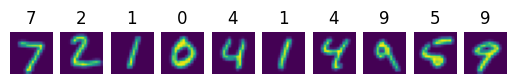

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
img = img.numpy().transpose(0,2,3,1)
label = label.numpy().squeeze()
for i in range(10):
  train_x = img[i]
  train_y = label[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y.item()))
  ax.axis("off")

plt.show()

### 4.2 Training Sequence
In this section, you are asked to implement the training sequence of the VAE.

### TODO
- Implement `self.optimizer` in the `__init__` function of the `training_VAE` class
    - You can use `Adam` optimizer with `config.lr` arguments
- Complete the `one_iter_train` function in the `training_VAE` class.
    - In the `one_iter_train` function, you should covers two cases: `AE` and `VAE` with `self.model_name` defined in the `__init__` function of the `training_VAE` class.


If training sequence of AE is implemented correctly, the below cell is executed without error and print the following result:


In [21]:
from HW4_1_YourAnswer import *
from copy import deepcopy
# for AE
test_config = deepcopy(config)
test_config.batch_size =2
test_config.latent_dim = 2
eps = torch.load('./test_file/test_eps.pth',map_location=device)
images = torch.load('./test_file/test_images_MNIST.pth',map_location=device)
labels = torch.load('./test_file/test_labels_MNIST.pth',map_location=device)

encoder = Encoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,model_name='AE').to(device)
decoder = Decoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,expand_dim=test_config.expand_dim).to(device)
# If you have trouble loading the model, please check the model architecture
encoder.load_state_dict(torch.load('./test_file/init_encoder.pth',map_location=device),strict=False)
decoder.load_state_dict(torch.load('./test_file/init_decoder.pth',map_location=device),strict=False)

trainer = training_VAE(train_loader = None, test_loader = None,
                       encoder=encoder, decoder=decoder,
                       device=device, config=test_config, save_img=False,
                       model_name='AE')
result = trainer.one_iter_train(images,labels,eps)
reference_result = torch.load('./test_file/test_results_AE.pth',map_location=device)
print("your implementation outcome is\n",result['recon_loss'])
print("The results should be\n",reference_result['recon_loss'])

assert abs(result['recon_loss'] - reference_result['recon_loss']) < 1e-2, "Reconstruction loss is wrong"


your implementation outcome is
 196.1310577392578
The results should be
 196.1310272216797


If training sequence of VAE is implemented correctly, the below cell is executed without error and print the following result:
```
your implementation outcome is
 {'recon_loss': 195.93630981445312, 'kld_loss': 0.015837177634239197}
The results should be
 {'recon_loss': 195.93630981445312, 'kld_loss': 0.015837177634239197}
```

In [23]:
from HW4_1_YourAnswer import *
from copy import deepcopy

# training VAE
test_config = deepcopy(config)
test_config.batch_size =2
test_config.latent_dim = 2
eps = torch.load('./test_file/test_eps.pth',map_location=device)
images = torch.load('./test_file/test_images_MNIST.pth',map_location=device)
labels = torch.load('./test_file/test_labels_MNIST.pth',map_location=device)

encoder = Encoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,model_name='VAE').to(device)
decoder = Decoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,expand_dim=test_config.expand_dim).to(device)
# If you have trouble loading the model, please check the model architecture
encoder.load_state_dict(torch.load('./test_file/init_encoder.pth',map_location=device))
decoder.load_state_dict(torch.load('./test_file/init_decoder.pth',map_location=device))

trainer = training_VAE(train_loader = None, test_loader = None,
                       encoder=encoder, decoder=decoder,
                       device=device, config=test_config, save_img=False)
result = trainer.one_iter_train(images,labels,eps)

reference_result = torch.load('./test_file/test_results_VAE.pth',map_location=device)
print("your implementation outcome is\n",result)
print("The results should be\n",reference_result)

assert abs(result['recon_loss'] - reference_result['recon_loss']) < 1e-2, "Reconstruction loss is wrong"
assert abs(result['kld_loss'] - reference_result['kld_loss']) < 1e-2, "KL divergence loss is wrong"

your implementation outcome is
 {'recon_loss': 195.93630981445312, 'kld_loss': 0.015837177634239197}
The results should be
 {'recon_loss': 195.93630981445312, 'kld_loss': 0.015837177634239197}


### 4.3 Training AE, VAE, and beta-VAE
With your implementation, you can train AE, VAE, and beta-VAE.

### Let's train AE!
Try to train AE with your own implemented code. You can train 20 epochs to get the reasonable result (It takes around 10 minutes to train 20 epoch).

Epoch [1/10], Step [235/234], Total loss : 65.111496 Recon Loss: 65.111496, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:22<00:00, 10.54it/s]


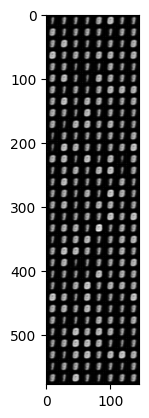

Epoch [2/10], Step [235/234], Total loss : 60.500885 Recon Loss: 60.500885, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:21<00:00, 10.72it/s]


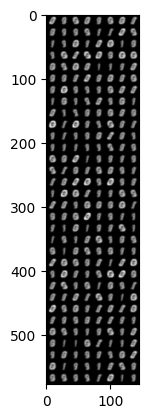

Epoch [3/10], Step [235/234], Total loss : 59.820709 Recon Loss: 59.820709, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:26<00:00,  8.96it/s]


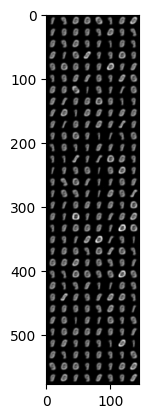

Epoch [4/10], Step [235/234], Total loss : 59.209522 Recon Loss: 59.209522, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:22<00:00, 10.47it/s]


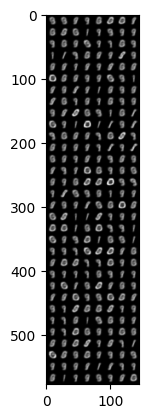

Epoch [5/10], Step [235/234], Total loss : 58.881317 Recon Loss: 58.881317, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:21<00:00, 10.68it/s]


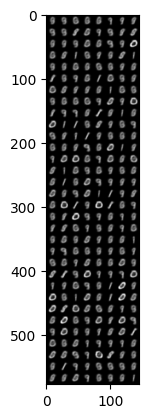

Epoch [6/10], Step [235/234], Total loss : 59.154053 Recon Loss: 59.154053, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:23<00:00, 10.03it/s]


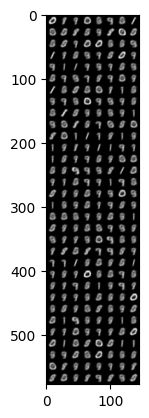

Epoch [7/10], Step [235/234], Total loss : 56.450531 Recon Loss: 56.450531, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:23<00:00, 10.07it/s]


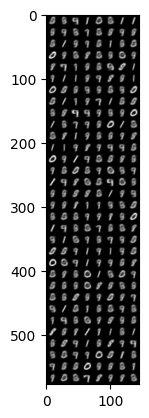

Epoch [8/10], Step [235/234], Total loss : 57.625053 Recon Loss: 57.625053, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:22<00:00, 10.23it/s]


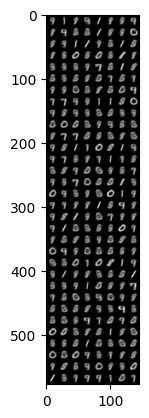

Epoch [9/10], Step [235/234], Total loss : 56.920433 Recon Loss: 56.920433, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:22<00:00, 10.44it/s]


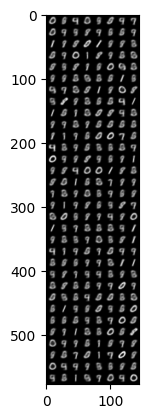

Epoch [10/10], Step [235/234], Total loss : 55.633110 Recon Loss: 55.633110, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:23<00:00,  9.91it/s]


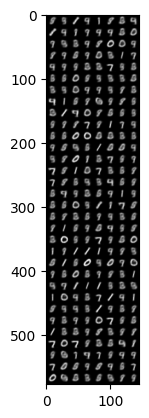

Saving gif file...


In [24]:
from HW4_1_YourAnswer import *
from utils import initialize_weights

train_loader = dataloader(train=True, batch_size=config.batch_size)
test_loader = dataloader(train=False, batch_size=config.batch_size)
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='AE').to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)
trainer = training_VAE(train_loader, test_loader,encoder, decoder, device, config, \
                       save_img=True,model_name='AE',beta=config.beta,img_show=True)
results_AE = trainer.train()

In [25]:
trained_encoder_AE = results_AE['encoder']
trained_decoder_AE = results_AE['decoder']
recon_loss_AE = results_AE['Recon_loss_history']

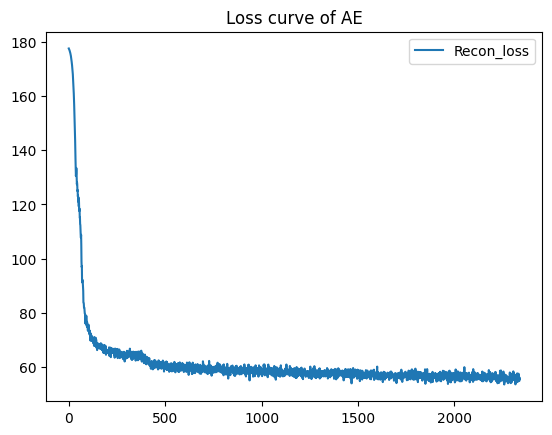

In [26]:
plt.title("Loss curve of AE")
plt.plot(recon_loss_AE, label='Recon_loss')
plt.legend()

### Let's train VAE!
Try to train VAE with your own implemented code (with beta 1). You can train 20 epochs to get the reasonable result. (It takes around 10 minutes to train 20 epoch.)

Epoch [1/10], Step [235/234], Total loss : 67.552964 Recon Loss: 66.634842, KLD Loss: 0.918122: 100%|██████████| 234/234 [00:22<00:00, 10.47it/s]


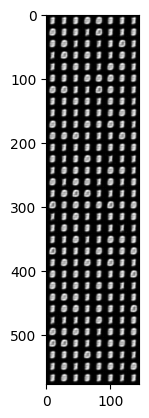

Epoch [2/10], Step [235/234], Total loss : 65.357849 Recon Loss: 63.961594, KLD Loss: 1.396255: 100%|██████████| 234/234 [00:21<00:00, 10.67it/s]


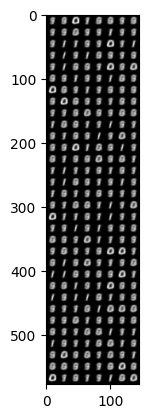

Epoch [3/10], Step [235/234], Total loss : 65.292204 Recon Loss: 63.936638, KLD Loss: 1.355566: 100%|██████████| 234/234 [00:22<00:00, 10.38it/s]


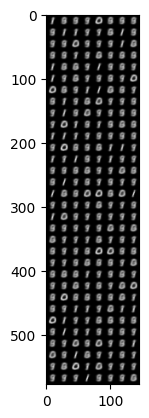

Epoch [4/10], Step [235/234], Total loss : 63.815180 Recon Loss: 61.197262, KLD Loss: 2.617918: 100%|██████████| 234/234 [00:22<00:00, 10.57it/s]


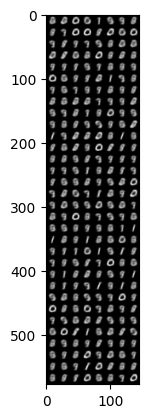

Epoch [5/10], Step [235/234], Total loss : 62.740890 Recon Loss: 59.756226, KLD Loss: 2.984664: 100%|██████████| 234/234 [00:23<00:00,  9.90it/s]


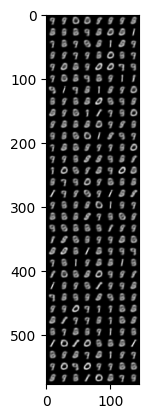

Epoch [6/10], Step [235/234], Total loss : 62.229192 Recon Loss: 59.210876, KLD Loss: 3.018315: 100%|██████████| 234/234 [00:22<00:00, 10.46it/s]


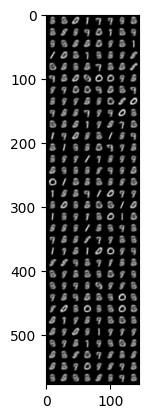

Epoch [7/10], Step [235/234], Total loss : 60.690065 Recon Loss: 57.523258, KLD Loss: 3.166807: 100%|██████████| 234/234 [00:23<00:00, 10.06it/s]


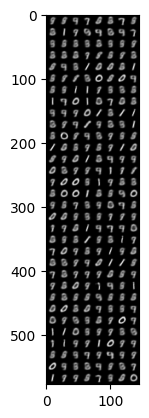

Epoch [8/10], Step [235/234], Total loss : 60.644466 Recon Loss: 57.435486, KLD Loss: 3.208981: 100%|██████████| 234/234 [00:22<00:00, 10.27it/s]


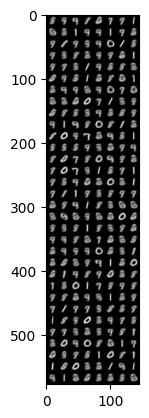

Epoch [9/10], Step [235/234], Total loss : 61.187104 Recon Loss: 58.037323, KLD Loss: 3.149781: 100%|██████████| 234/234 [00:23<00:00, 10.00it/s]


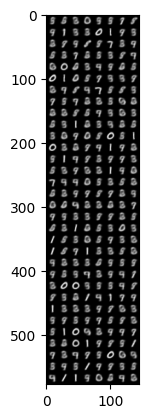

Epoch [10/10], Step [235/234], Total loss : 61.903411 Recon Loss: 58.494537, KLD Loss: 3.408874: 100%|██████████| 234/234 [00:23<00:00, 10.15it/s]


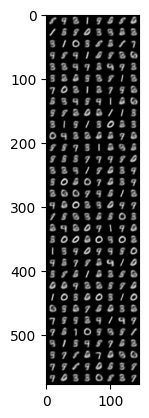

Saving gif file...


In [27]:
from HW4_1_YourAnswer import *
from utils import initialize_weights
config.beta = 1
train_loader = dataloader(train=True, batch_size=config.batch_size)
test_loader = dataloader(train=False, batch_size=config.batch_size)
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,model_name='VAE').to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)
trainer = training_VAE(train_loader, test_loader,encoder, decoder, device, config, \
                       save_img=True,model_name='VAE',beta=config.beta,img_show=True)
results_VAE = trainer.train()

In [28]:
trained_encoder_VAE = results_VAE['encoder']
trained_decoder_VAE = results_VAE['decoder']
recon_loss_VAE= results_VAE['Recon_loss_history']
KLD_loss_VAE= results_VAE['KLD_loss_history']

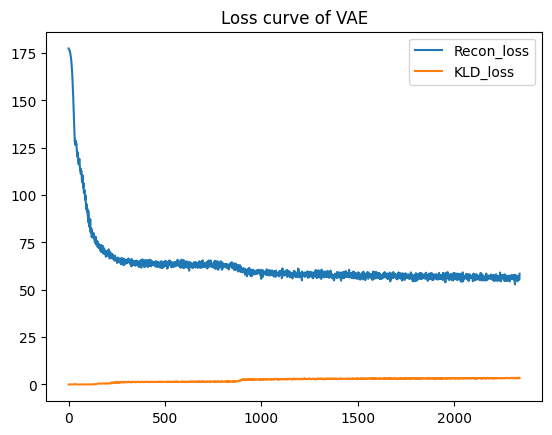

In [29]:
plt.title("Loss curve of VAE")
plt.plot(recon_loss_VAE, label='Recon_loss')
plt.plot(KLD_loss_VAE, label='KLD_loss')
plt.legend()

### Let's train beta-VAE!
Try to train beta-VAE with your own implemented code (with beta 2). You can train 20 epochs to get the reasonable result. (It takes around 10 minutes to train 20 epoch.) If you want to get the results depending on the beta, you can change the beta value in the `training_VAE` class.

Epoch [1/10], Step [235/234], Total loss : 71.147454 Recon Loss: 70.678162, KLD Loss: 0.469293: 100%|██████████| 234/234 [00:23<00:00,  9.95it/s]


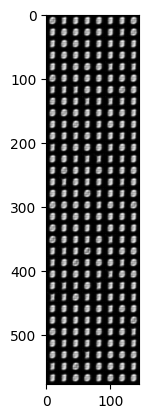

Epoch [2/10], Step [235/234], Total loss : 67.239830 Recon Loss: 66.333138, KLD Loss: 0.906693: 100%|██████████| 234/234 [00:22<00:00, 10.29it/s]


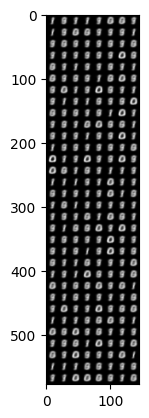

Epoch [3/10], Step [235/234], Total loss : 67.034439 Recon Loss: 65.971230, KLD Loss: 1.063210: 100%|██████████| 234/234 [00:22<00:00, 10.62it/s]


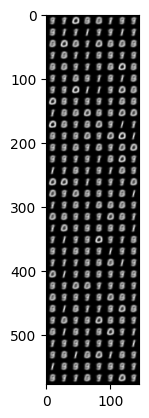

Epoch [4/10], Step [235/234], Total loss : 64.473238 Recon Loss: 63.361744, KLD Loss: 1.111495: 100%|██████████| 234/234 [00:23<00:00,  9.91it/s]


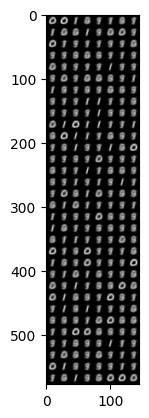

Epoch [5/10], Step [235/234], Total loss : 65.296366 Recon Loss: 64.147736, KLD Loss: 1.148630: 100%|██████████| 234/234 [00:22<00:00, 10.35it/s]


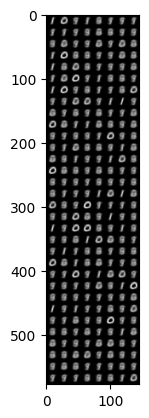

Epoch [6/10], Step [235/234], Total loss : 63.055177 Recon Loss: 61.881836, KLD Loss: 1.173341: 100%|██████████| 234/234 [00:22<00:00, 10.19it/s]


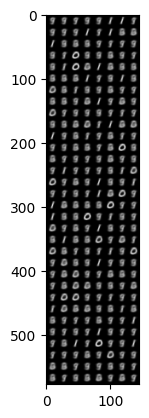

Epoch [7/10], Step [235/234], Total loss : 62.626916 Recon Loss: 61.299358, KLD Loss: 1.327557: 100%|██████████| 234/234 [00:23<00:00, 10.10it/s]


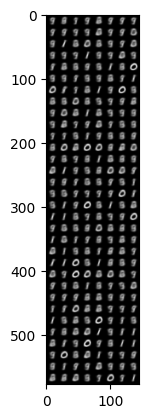

Epoch [8/10], Step [235/234], Total loss : 62.490036 Recon Loss: 60.514725, KLD Loss: 1.975311: 100%|██████████| 234/234 [00:22<00:00, 10.25it/s]


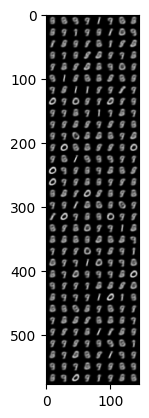

Epoch [9/10], Step [235/234], Total loss : 62.194252 Recon Loss: 60.209015, KLD Loss: 1.985237: 100%|██████████| 234/234 [00:23<00:00,  9.91it/s]


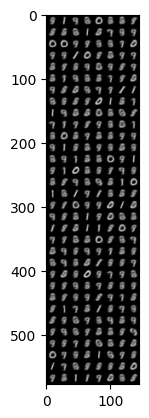

Epoch [10/10], Step [235/234], Total loss : 59.636618 Recon Loss: 57.215439, KLD Loss: 2.421179: 100%|██████████| 234/234 [00:22<00:00, 10.19it/s]


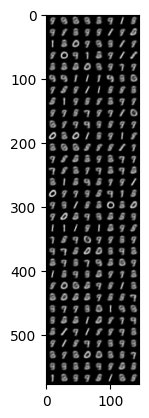

Saving gif file...


In [30]:
from HW4_1_YourAnswer import *
from utils import initialize_weights
config.beta = 2
train_loader = dataloader(train=True, batch_size=config.batch_size)
test_loader = dataloader(train=False, batch_size=config.batch_size)
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,model_name='VAE').to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)
trainer = training_VAE(train_loader, test_loader,encoder, decoder, device, config, \
                       save_img=True,model_name='beta_VAE',beta=config.beta,img_show=True)
results_beta_VAE = trainer.train()

In [31]:
trained_encoder_beta_VAE = results_beta_VAE['encoder']
trained_decoder_beta_VAE = results_beta_VAE['decoder']
recon_loss_beta_VAE= results_beta_VAE['Recon_loss_history']
KLD_loss_beta_VAE= results_beta_VAE['KLD_loss_history']

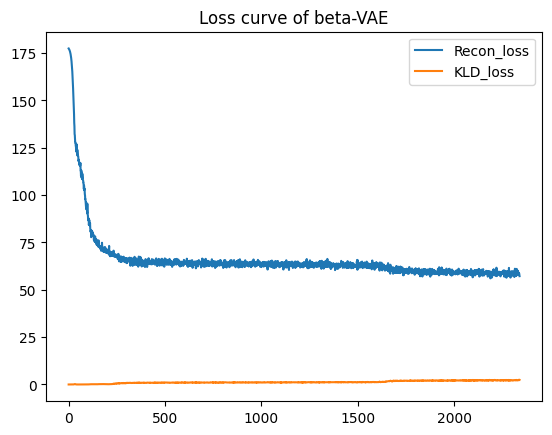

In [32]:
plt.title("Loss curve of beta-VAE")
plt.plot(recon_loss_beta_VAE, label='Recon_loss')
plt.plot(KLD_loss_beta_VAE, label='KLD_loss')
plt.legend()

## Visualization of the training result
If you implement the `training_VAE` class correctly, you can get the following result:
- The generated image of the AE, VAE, and beta-VAE from same images
- The reconstructed image of the AE, VAE, and beta-VAE from same images
- The representation of the output with the change of latent vector
- Visualization of the latent space mapping of the VAE and AutoEncoder
- Visualization of the output image depending on the latent vector

In [33]:
from HW4_1_YourAnswer import dataloader
import math
test_loader = dataloader(train=False, batch_size=64)
num_col=8
for batch_idx, (image, label) in enumerate(test_loader):
    image = (image).to(device)
    param = trained_encoder_AE(image)
    output_AE = trained_decoder_AE(param)
    grid_output_AE = torchvision.utils.make_grid(output_AE, nrow=num_col, normalize=True).cpu().detach().permute(1,2,0).numpy()
    mu, log_var, reparam = trained_encoder_VAE(image)
    output_VAE = trained_decoder_VAE(reparam)
    grid_output_VAE = torchvision.utils.make_grid(output_VAE, nrow=num_col, normalize=True).cpu().detach().permute(1,2,0).numpy()
    mu, log_var, beta_reparam = trained_encoder_beta_VAE(image)
    output_beta_VAE = trained_decoder_beta_VAE(beta_reparam)
    grid_output_beta_VAE = torchvision.utils.make_grid(output_beta_VAE, nrow=num_col, normalize=True).cpu().detach().permute(1,2,0).numpy()
    break

Let's compare the generated images of the AE, VAE, and beta-VAE.

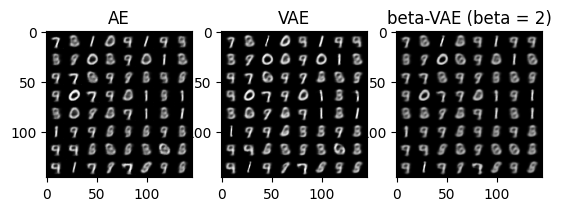

In [34]:
plt.subplot(1,3,1)
plt.title("AE")
plt.imshow(grid_output_AE)
plt.subplot(1,3,2)
plt.title("VAE")
plt.imshow(grid_output_VAE)
plt.subplot(1,3,3)
plt.title(f"beta-VAE (beta = {config.beta})")
plt.imshow(grid_output_beta_VAE)

### The reconstructed image of the AE, VAE, and beta-VAE from same images
If you implement the `training_VAE` class correctly, you can see the input image and the output image of the VAE. The input image is the leftmost image, and the output image is the 2nd,3rd and 4th image from left. It might fail to reconstruct the input image due to insufficient training, but you can see that the output image is similar to the input image.

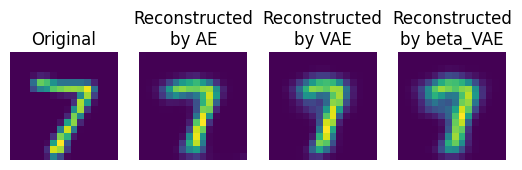

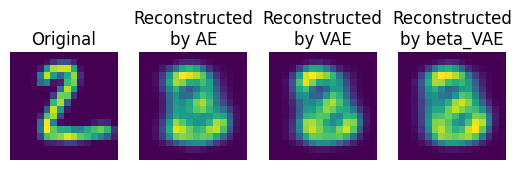

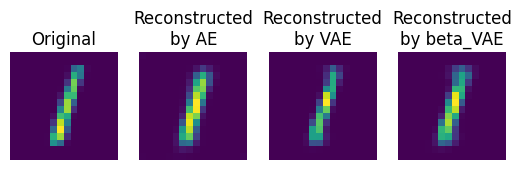

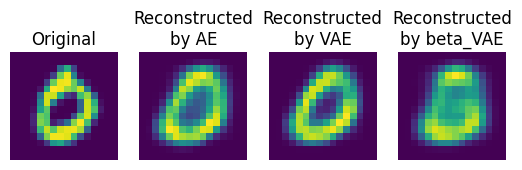

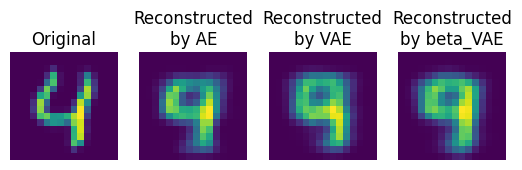

In [35]:
output = {'AE':output_AE.detach().cpu().numpy(),
          'VAE':output_VAE.detach().cpu().numpy(),
          'beta_VAE':output_beta_VAE.detach().cpu().numpy()}
show_image_real_and_VAE(image,output,num_img=5)


### The representation of the output with the change of latent vector
In the following figure, you will see the visualization of the output image depending on the latent vector. Since the AE does not consider the distribution of the latent vector, the output image sometimes cannot produces image depending on the latent vector. On the other hand, the VAE considers the distribution of the latent vector, so the output image is changed depending on the latent vector. The image will be changed smoothly because the latent vector is sampled from the Gaussian distribution.

The generated image is as follows:

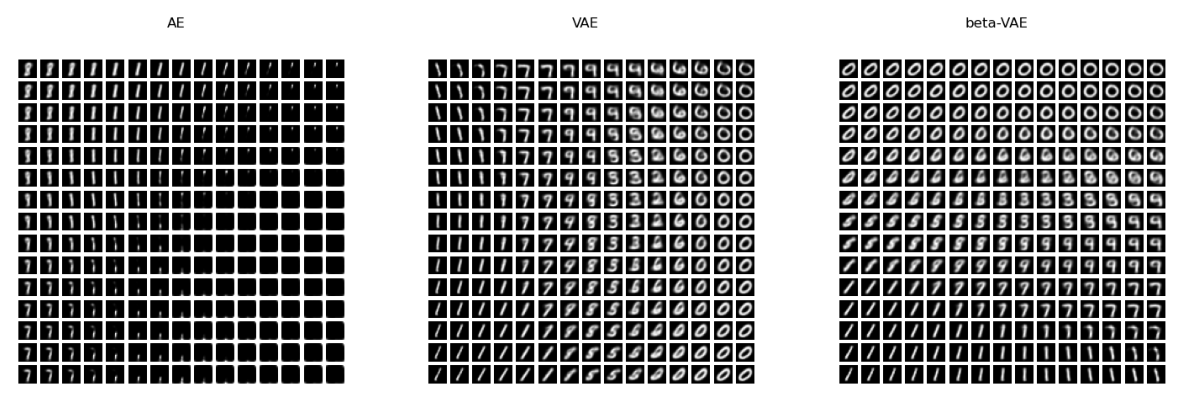

In [36]:
AE_img = cv2.imread("./test_file/AE_latent_vector_img.png")
VAE_img = cv2.imread("./test_file/VAE_latent_vector_img.png")
beta_VAE_img = cv2.imread("./test_file/beta_VAE_latent_vector_img.png")
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(AE_img)
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(VAE_img)
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(beta_VAE_img)

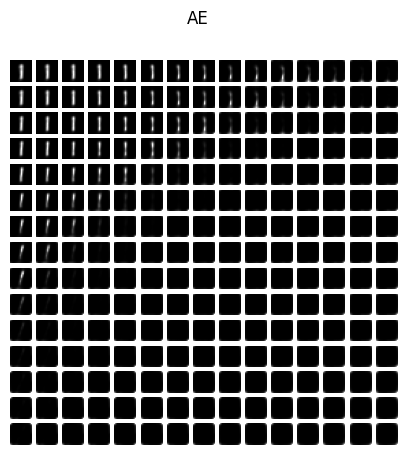

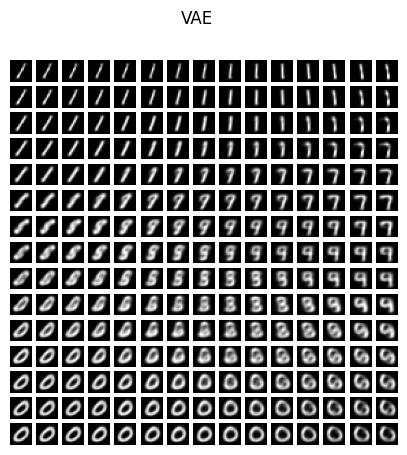

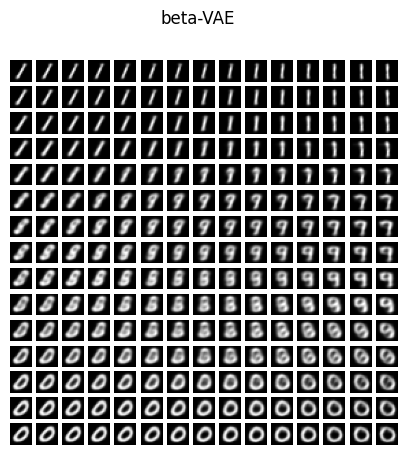

In [37]:
config.latent_dim = 2
show_image_VAE('AE',trained_decoder_AE,config.latent_dim,size=15)
plt.pause(0.01)
show_image_VAE('VAE',trained_decoder_VAE,config.latent_dim,size=15)
plt.pause(0.01)
show_image_VAE('beta-VAE',trained_decoder_beta_VAE,config.latent_dim,size=15)
plt.pause(0.01)

# Visualization of the latent vector of the VAE and AE
In this section, you are asked to visualize the latent vector of the VAE and AE with your implementation. Just run and see the visualization. The visualization of the latent vector is performed to compare the latent vector of the VAE and AE.

For comparison, we will use the trained AE and VAE with same structure.

When you get the figure, the latent vector of the VAE and AE is visualized. The latent vector of the VAE is on the left, and the latent vector of the AE is on the right.

The latent vector of the VAE is more evenly distributed and centered among origin point than the latent vector of the AE. This is because the VAE is trained with the KL divergence loss, which makes the latent vector evenly distributed. Therefore, it has benefit to generate more diverse images. It leads to understanding the latent vector of the VAE is more interpretable than the AE latent vector. Due to insufficient training, the latent vector of the AE and VAE might be quite far from the wanted distribution.. However, you can see the difference between the latent vector of the VAE and AE.

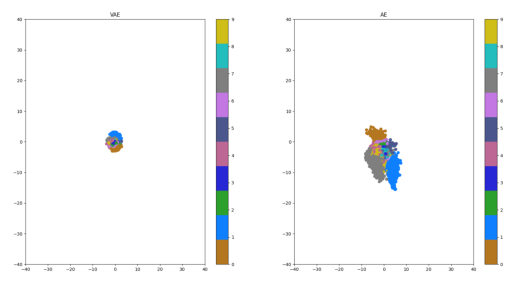

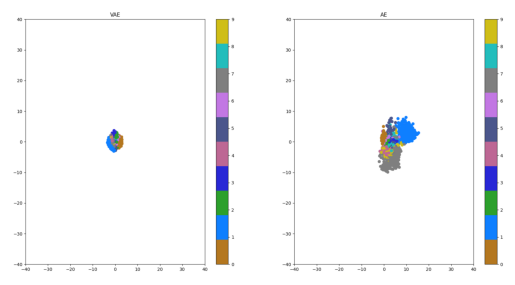

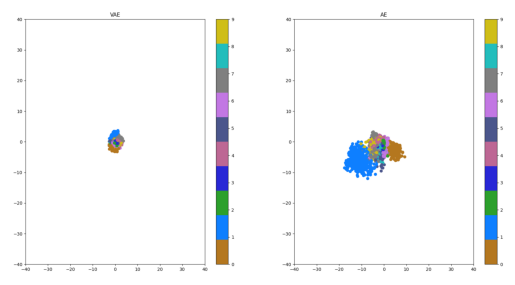

In [38]:
import cv2
import matplotlib.pyplot as plt
output = cv2.imread("./test_file/VAE_AE_output.png")
plt.axis('off')
plt.imshow(output)
plt.pause(0.01)
output = cv2.imread("./test_file/VAE_AE_output_1.png")
plt.axis('off')
plt.imshow(output)
plt.pause(0.01)
output = cv2.imread("./test_file/VAE_AE_output_2.png")
plt.axis('off')
plt.imshow(output)

### Let's compare the latent vector of the VAE and AE!

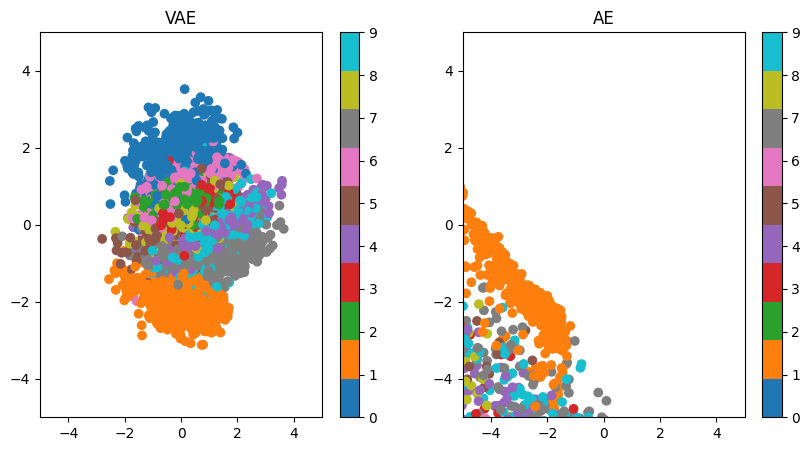

In [39]:
plt.figure(figsize=(10,5))
visualize_latent_dim(trained_encoder_VAE, title='VAE',position='left')
visualize_latent_dim(trained_encoder_AE, title='AE',position='right')

## The generated image of the VAE depending on the latent vector dimension
From now, the latent vector of the VAE is 2-dimensional. Let's change the dimension of latent vector with 5,10 and see the change of results. Here, the model is trained for 15 epochs since the larger dimension of latent vector needs more training. After training, you can see the generated image of the VAE depending on the latent vector dimension with the same noise, `eps`. It might be very marginal difference, but you can see the difference between the generated image of the VAE depending on the latent vector dimension.

In [40]:
from HW4_1_YourAnswer import *
VAEs = []
config.epoch = 20
for latent_dim in [5,10]:
    # train VAE
    config.latent_dim = latent_dim
    train_loader = dataloader(train=True, batch_size=config.batch_size)
    test_loader = dataloader(train=False, batch_size=config.batch_size)
    encoder_high_dim = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,model_name='VAE').to(device)
    decoder_high_dim = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)

    trainer_high_dim = training_VAE(train_loader, test_loader,encoder_high_dim, decoder_high_dim, device, config, \
                           save_img=False,model_name='VAE',beta=1,img_show=False)
    results_high_dim = trainer_high_dim.train()
    trained_encoder_VAE_high_dim = results_high_dim['encoder']
    trained_decoder_VAE_high_dim = results_high_dim['decoder']
    VAEs.append((latent_dim,trained_encoder_VAE_high_dim,trained_decoder_VAE_high_dim))

Epoch [1/20], Step [235/234], Total loss : 63.827633 Recon Loss: 61.896114, KLD Loss: 1.931519: 100%|██████████| 234/234 [00:21<00:00, 10.70it/s]
Epoch [2/20], Step [235/234], Total loss : 58.585447 Recon Loss: 53.915474, KLD Loss: 4.669973: 100%|██████████| 234/234 [00:22<00:00, 10.46it/s]
Epoch [3/20], Step [235/234], Total loss : 56.741584 Recon Loss: 51.014568, KLD Loss: 5.727015: 100%|██████████| 234/234 [00:22<00:00, 10.61it/s]
Epoch [4/20], Step [235/234], Total loss : 54.318176 Recon Loss: 48.283310, KLD Loss: 6.034866: 100%|██████████| 234/234 [00:22<00:00, 10.63it/s]
Epoch [5/20], Step [235/234], Total loss : 55.426020 Recon Loss: 49.327061, KLD Loss: 6.098959: 100%|██████████| 234/234 [00:22<00:00, 10.60it/s]
Epoch [6/20], Step [235/234], Total loss : 55.235600 Recon Loss: 48.905235, KLD Loss: 6.330364: 100%|██████████| 234/234 [00:21<00:00, 10.69it/s]
Epoch [7/20], Step [235/234], Total loss : 56.906908 Recon Loss: 50.272808, KLD Loss: 6.634100: 100%|██████████| 234/234 [00

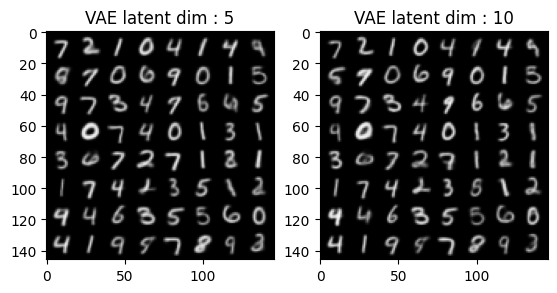

In [41]:
from HW4_1_YourAnswer import dataloader
test_loader = dataloader(train=False, batch_size=64)
for image,label in test_loader:
    image = image.to(device)
    break
plt.figure(figsize=(10, 10))
eps = torch.randn(64, 20).to(device)
for i in range(len(VAEs)):
    latent_dim,trained_encoder_VAE,trained_decoder_VAE = VAEs[i]
    _, _, rp = trained_encoder_VAE(image,eps[:,:latent_dim])
    output = trained_decoder_VAE(rp)
    output = torchvision.utils.make_grid(output.cpu().detach(), nrow=8)
    output = output.numpy().transpose(1,2,0)
    plt.subplot(1,3, i+1)
    plt.title(f"VAE latent dim : {latent_dim}")
    plt.imshow(output)